## Signal visualization tutorial on Restricted ImageNet (20 classes)

Out method extracts signals from the input data, removes noise, computes input gradients and the heatmaps for top-k predictions. The heatmaps are computed for each of the top-k classes as follows:
* [a]. Heatmap for each class - A heatmap is computed on the gradient of a specified output class w.r.t the input


* [b]. Difference heatmaps - We want to understand strength of gradients of the top class (`class_0`) $\textit{relative}$ to the gradient of `class_1`, `class_2`, ... `class_k` as follows:
    * difference of input gradients of `class_0` and `class_1` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_0 - \nabla_{\textbf{X}_i} O_1), 0\}$)
    * difference of input gradients of `class_0` and `class_2` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_0 - \nabla_{\textbf{X}_i} O_2), 0\}$)
    * difference of input gradients of `class_0` and `class_k` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_0 - \nabla_{\textbf{X}_i} O_k), 0\}$)


* [c]. Inverse Difference heatmaps - We want to understand strength of gradients of prediction classes w.r.t the top prediction as follows:
    * difference of input gradients of `class_1` and `class_0` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_1 - \nabla_{\textbf{X}_i} O_0), 0\}$)
    * difference of input gradients of `class_2` and `class_0` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_2 - \nabla_{\textbf{X}_i} O_0), 0\}$)
    * difference of input gradients of `class_k` and `class_0` i.e., heatmap($ \textit{Max}\{ (\nabla_{\textbf{X}_i} O_k - \nabla_{\textbf{X}_i} O_0), 0\}$)
    
Following naming convention is used to save heatmaps: `modelName_methodName_class_k.JPEG` where `class_0` refers to the top prediction and `class_k` refers to the `k-th` top prediction 

#### [1] Load necessary modules and set a seed across devices to reproduce results

In [13]:
import os
import torch
import random
torch.set_printoptions(precision=8)
from untangle import UntangleAI
from torchvision import models
untangle_ai = UntangleAI()
from tqdm import tqdm
from torchvision import transforms
from torchvision import datasets
import numpy as np
from IPython.display import Image

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(42)

#### [2] Define relevant arguments. Descriptions are as follows:

* `mname` [`<class str>`] - base name / prefix to generate visualization files
* `batch_size` [`<class int>`, `default:16`] - batch size to scan the training data and learn internal statistics. We observed that a Tesla K80, 12Gb GPU can accommodate a batch size of `16` for a standard (224,224) RGB image
* `num_classes` [`<class int>`] - number of classes in the dataset
* `input_tensor` [`<class torch.Tensor>`] - input to get visual explanation for. One can ignore this option and provide their own input tensor later on (as describe in this tutorial)
* `input_tensor_true` [`<class torch.Tensor> or <class numpy.ndarray> or <class PIL.Image.Image>`] - same as above, expect that this input has to be unnormalized (actual image). Can be ndarray, torch tensor or a PIL Image object.
* `data_class` [`<class list> or <class NoneType>`, `default:None`] - list of class indices to learn a visual explanation for. If `None`, then learn explanations for all classes.
* `mode` [`<class str>`, `default:estimate`] - In order to get visual explanations, we need to estimate internal statistics of each class. Hence, `mode=estimate` must happen before calling `mode=attribute`. Note that `mode=estimate` estimates internal statistics for class specified by `data_class`. Hence, only for those class, we can obtain signal attributes (visual explanations)
* `topk` [`<class str>`, `default:5`] - Get the heatmaps for the top-k model predictions. Heatmaps are computed jointly across the topk classes as outlined below


In [15]:
class Args:
    mname = 'vgg16_imgnet20' # base name to generate visualization files
    batch_size = 16
    num_classes = 20
    img_size = (3,224,224)
    input_tensor = torch.randn(1,3,224,224) # provide your own input tensor
    input_tensor_true = torch.randn(224,224,3) # provide your own true input tensor / ndarray / PIL Image Obj
    data_class = None # list of class indices, or `None` to estimate all classes
    mode = 'estimate' # one of `estimate`, `attribute`
    topk = 5 # topk predictions to get visualizations for
    cmap = 'seismic' # heatmap color map
    json = False # if true, the script saves the heatmap values in a json format
    hm_diff = 'joint' # default. Leave it unchanged
    use_smoothgrad = False
    stdev_spread = 0.05 # for smoothGrad only. Ignored if `use_smoothgrad=False`
    mean = 0.0 # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    nsamples = 25 # for smoothGrad only.  Ignored if `use_smoothgrad=False`
    magnitude = False # for smoothGrad only.  Ignored if `use_smoothgrad=False`

#### [3] Define a torch model. Here, we modify VGG16 from torchvision to output 20 probabilities. 

In [3]:
import torch
from torchvision.models import vgg16

class CustomVgg16(torch.nn.Module):
    def __init__(self, num_classes=10, use_pretrained=False):
        super(CustomVgg16, self).__init__()
        base_model = vgg16(pretrained=use_pretrained)

        modules = list(base_model.children())
        self.features = torch.nn.Sequential(*modules[:-1])

        classifier = list(modules[-1].children())[:-1]
        classifier += [torch.nn.Linear(4096, num_classes)]
        self.classifier = torch.nn.Sequential(*classifier)

    def forward(self, input):
        output = self.features(input)
        output = output.view(input.shape[0], -1)
        output = self.classifier(output)
        return(output)

#### [4] Define data / models paths and class name to index mapping

* `ID2Name_Map`: Defaults to class indices as names. User can choose to provide custom names of classes to appear in the generated results.
* `model_ckpt_path`: path to pretrained model state dict
* `model_signal_data_path`: base path to store interal signal statistics of each class
* `results_path`: path to save visualization results

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
args = Args()
keys = [str(item) for item in range(args.num_classes)]
ID2Name_Map = dict(zip(keys, keys)) # backward compatibility to existing codebase

module_path = os.path.abspath('')
base_model_path = os.path.join(module_path, 'models')
model_ckpt_path = os.path.join(base_model_path, 'vgg16_imgnet20_pretrained.pth')
data_path = os.path.join(module_path, 'data')
train_path = os.path.join(data_path, 'imagenet20_data/train')
model_signal_data_path = os.path.join(module_path, 'model_signal_data/')
results_path = os.path.join(module_path, 'results')
if(not os.path.exists(model_signal_data_path)):
    os.makedirs(model_signal_data_path)
if(not os.path.exists(results_path)):
    os.makedirs(results_path)
signal_store_path = os.path.join(model_signal_data_path, '{}_signals'.format(args.mname))


#### [5] Load pre-trained weights into torch model and define transforms to be applied to the data

In [5]:
print("Loading model checkpoint...", end="", flush=True)
model = CustomVgg16(num_classes=args.num_classes, use_pretrained=False)
model = model.to(DEVICE)
if (torch.cuda.is_available()):
    ckpt = torch.load(model_ckpt_path)
    model.load_state_dict(ckpt)
    model = model.cuda()
else:
    ckpt = torch.load(model_ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt)
print("Done!")
model.eval()

in_transform = transforms.Compose([
    transforms.Resize((args.img_size[1]+32, args.img_size[2]+32)),
    transforms.CenterCrop((args.img_size[1], args.img_size[2])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

Loading model checkpoint...Done!


#### [6] Prepare methods to get training images class by class

In [18]:
def get_train_idx_for_class(target, data_class='0'):
    output = []
    for i in range(len(target)):
        if(target[i] == int(data_class)):
            output.append(i)
    return(output)

def load_from_dir_per_class(dataroot, data_class='0', batch_size=128, transform=None, shuffle=False, get_paths=False):
    if(transform is None):
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        transform = transforms.Compose([transforms.ToTensor(), normalize])
    if(get_paths):
        testsetout = ImageFolderWithPaths(dataroot, transform=transform)
    else:
        testsetout = datasets.ImageFolder(dataroot, transform=transform)
    data_indices = get_train_idx_for_class(testsetout.targets, data_class)
    data_loader = torch.utils.data.DataLoader(testsetout, batch_size=batch_size, shuffle=shuffle,
                                               sampler=torch.utils.data.sampler.SubsetRandomSampler(data_indices))
    return(data_loader)

#### [7] Estimate internal signal statistics for the classes specified by `args.data_class`

In [ ]:
if(args.mode == 'estimate'):
    def train_loader_fun(class_i):
        loader = load_from_dir_per_class(train_path, data_class=class_i, batch_size=args.batch_size,
                                         transform=in_transform, shuffle=False, get_paths=False)
        return(loader)
    model.eval()
    untangle_ai.estimate_signals(model, signal_store_path, train_loader_fun, args)

Estimating signals for class: `0`


100%|██████████| 63/63 [08:45<00:00,  8.35s/it]


signals saved in path: /home/jupyter/Main-Platform/services/model_signal_data/vgg16_imgnet20_signals_class_0.pkl
Estimating signals for class: `1`


100%|██████████| 63/63 [08:17<00:00,  7.90s/it]


signals saved in path: /home/jupyter/Main-Platform/services/model_signal_data/vgg16_imgnet20_signals_class_1.pkl
Estimating signals for class: `2`


100%|██████████| 63/63 [16:19<00:00, 15.54s/it]


signals saved in path: /home/jupyter/Main-Platform/services/model_signal_data/vgg16_imgnet20_signals_class_2.pkl
Estimating signals for class: `3`


 33%|███▎      | 21/63 [06:08<06:09,  8.79s/it]

#### [8] Define class indices to imagenet synset mapping. For the given imagenet20 dataset, Pytorch outputs the probablity indices in range [0,19]. Hence, we need a mapping to map the [0,19] indices back to the indices in original imagenet dataset ([0,999] range)

In [8]:
Synset20toID_Map = {'n01484850': '0', 'n01491361': '1', 'n02123159': '2', 'n02124075': '3', 'n02687172': '4', 'n02799071': '5',
                    'n02906734': '6', 'n02974003': '7', 'n03272010': '8', 'n03977966': '9', 'n04146614': '10', 'n04154565': '11',
                    'n04251144': '12','n04285008': '13', 'n04335435': '14', 'n04356056': '15', 'n07720875': '16',
                    'n07742313': '17', 'n07745940': '18', 'n09256479': '19'}
ID2Synset20_Map = {val:key for key, val in Synset20toID_Map.items()}
synset_map_path = os.path.join(data_path, 'synset_mapping.txt')
if (not os.path.exists(synset_map_path)):
    raise FileNotFoundError(synset_map_path)
Synset2ID_Map = {}
with open(synset_map_path) as f:
    for line in f:
        (idx, synset) = line.split(':')
        Synset2ID_Map[synset.strip()] = str(idx)
for key, val in ID2Synset20_Map.items():
    ID2Name_Map[key] = Synset2ID_Map[val]

img_path = './bell_pepper.JPEG'
input_tensor, input_img = untangle_ai.load_adHoc_image(img_path)
input_tensor = input_tensor.cuda()
input_img = np.asarray(input_img)
img_name = img_path.split('/')[-1].split('.')[0].strip()
out_prefix = os.path.join(results_path, '{}_smoothGrad_{}_{}_signals'.format(args.mname, args.use_smoothgrad, img_name))

#### [9] Get signal visualization (attributes) for a given input image. The method returns a list of input gradients computed for each class. User can choose to save it for further investigation

In [10]:
topk_gradients = untangle_ai.attribute_signals(model, input_tensor, input_img, signal_store_path, ID2Name_Map, args, out_prefix)

Top-5 class(es): ['948', '945', '949', '462', '973']
Top-5 indices(s): [17, 16, 18, 6, 19]
Top-5 logit(s): [19.745153, 16.581026, 6.385593, 5.947206, 5.7848997]
Top-5 probs(s): [0.9594586, 0.04053808, 1.5137113e-06, 9.76459e-07, 8.3016624e-07]
----------------------------------------------------------------------
     Signal visualization for class: 948 [17]
----------------------------------------------------------------------
Using signals: /home/jupyter/Main-Platform/services/model_signal_data/vgg16_imgnet20_signals_class_17.pkl
----------------------------------------------------------------------
     Signal visualization for class: 945 [16]
----------------------------------------------------------------------
Using signals: /home/jupyter/Main-Platform/services/model_signal_data/vgg16_imgnet20_signals_class_16.pkl
----------------------------------------------------------------------
     Signal visualization for class: 949 [18]
---------------------------------------------------

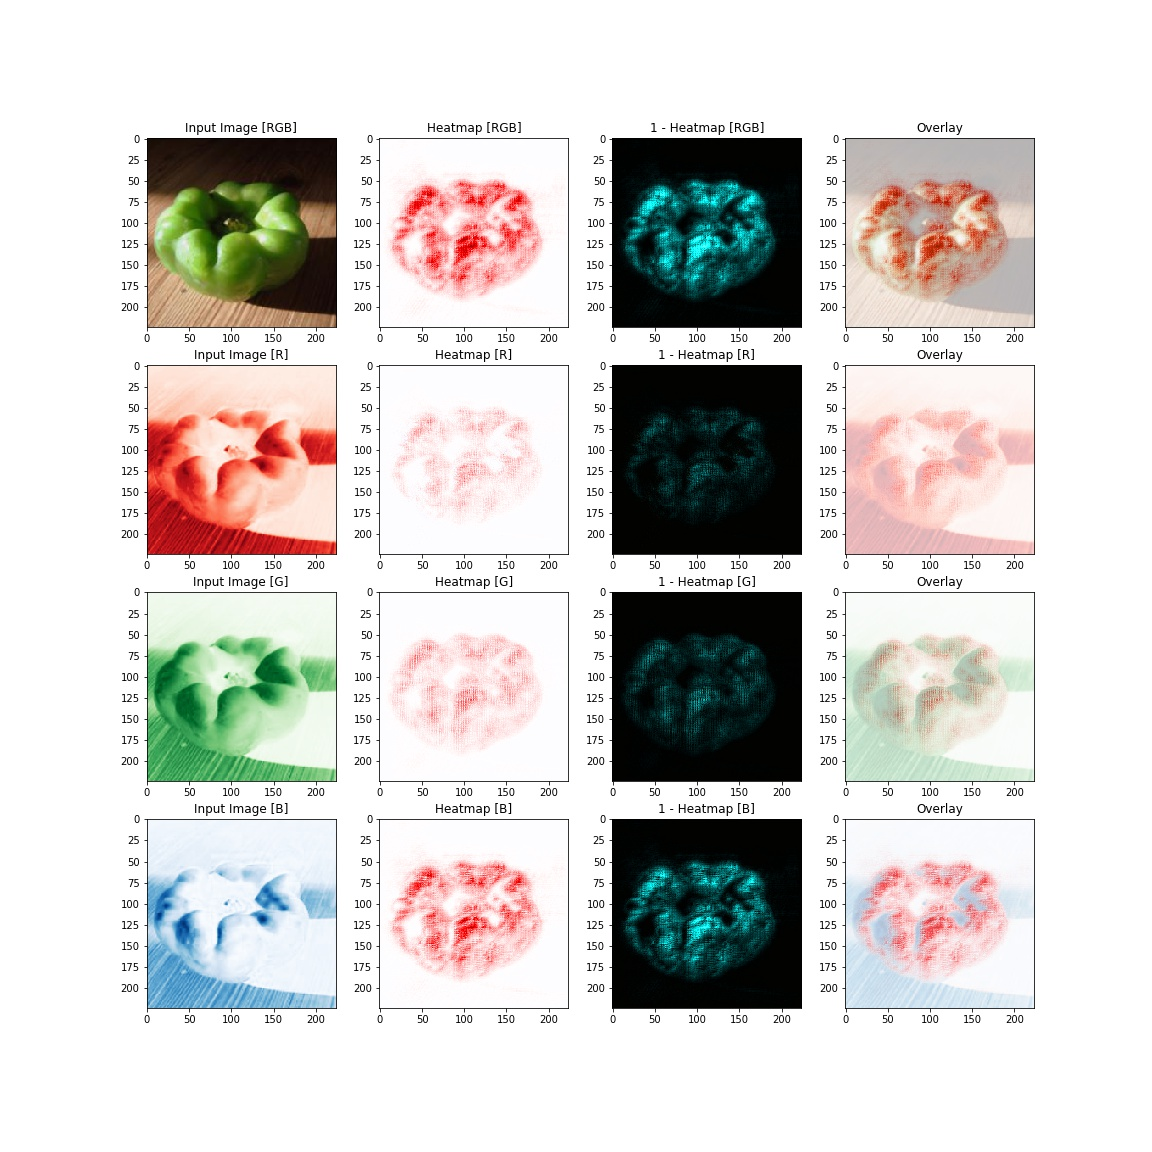

In [14]:
Image("/home/jupyter/Main-Platform/services/results/vgg16_imgnet20_smoothGrad_False_bell_pepper_signals_class_0.JPEG")